STEP 1: GENERATING SYNTHETIC DATASET
Dataset created with 10000 transactions
Shape: (10000, 31)

Class distribution:
Class
0    9650
1     350
Name: count, dtype: int64
Fraud percentage: 3.50%

STEP 2: EXPLORATORY DATA ANALYSIS

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      10000 non-null  float64
 1   V2      10000 non-null  float64
 2   V3      10000 non-null  float64
 3   V4      10000 non-null  float64
 4   V5      10000 non-null  float64
 5   V6      10000 non-null  float64
 6   V7      10000 non-null  float64
 7   V8      10000 non-null  float64
 8   V9      10000 non-null  float64
 9   V10     10000 non-null  float64
 10  V11     10000 non-null  float64
 11  V12     10000 non-null  float64
 12  V13     10000 non-null  float64
 13  V14     10000 non-null  float64
 14  V15     10000 non-null  float64
 15  V16     10000 n

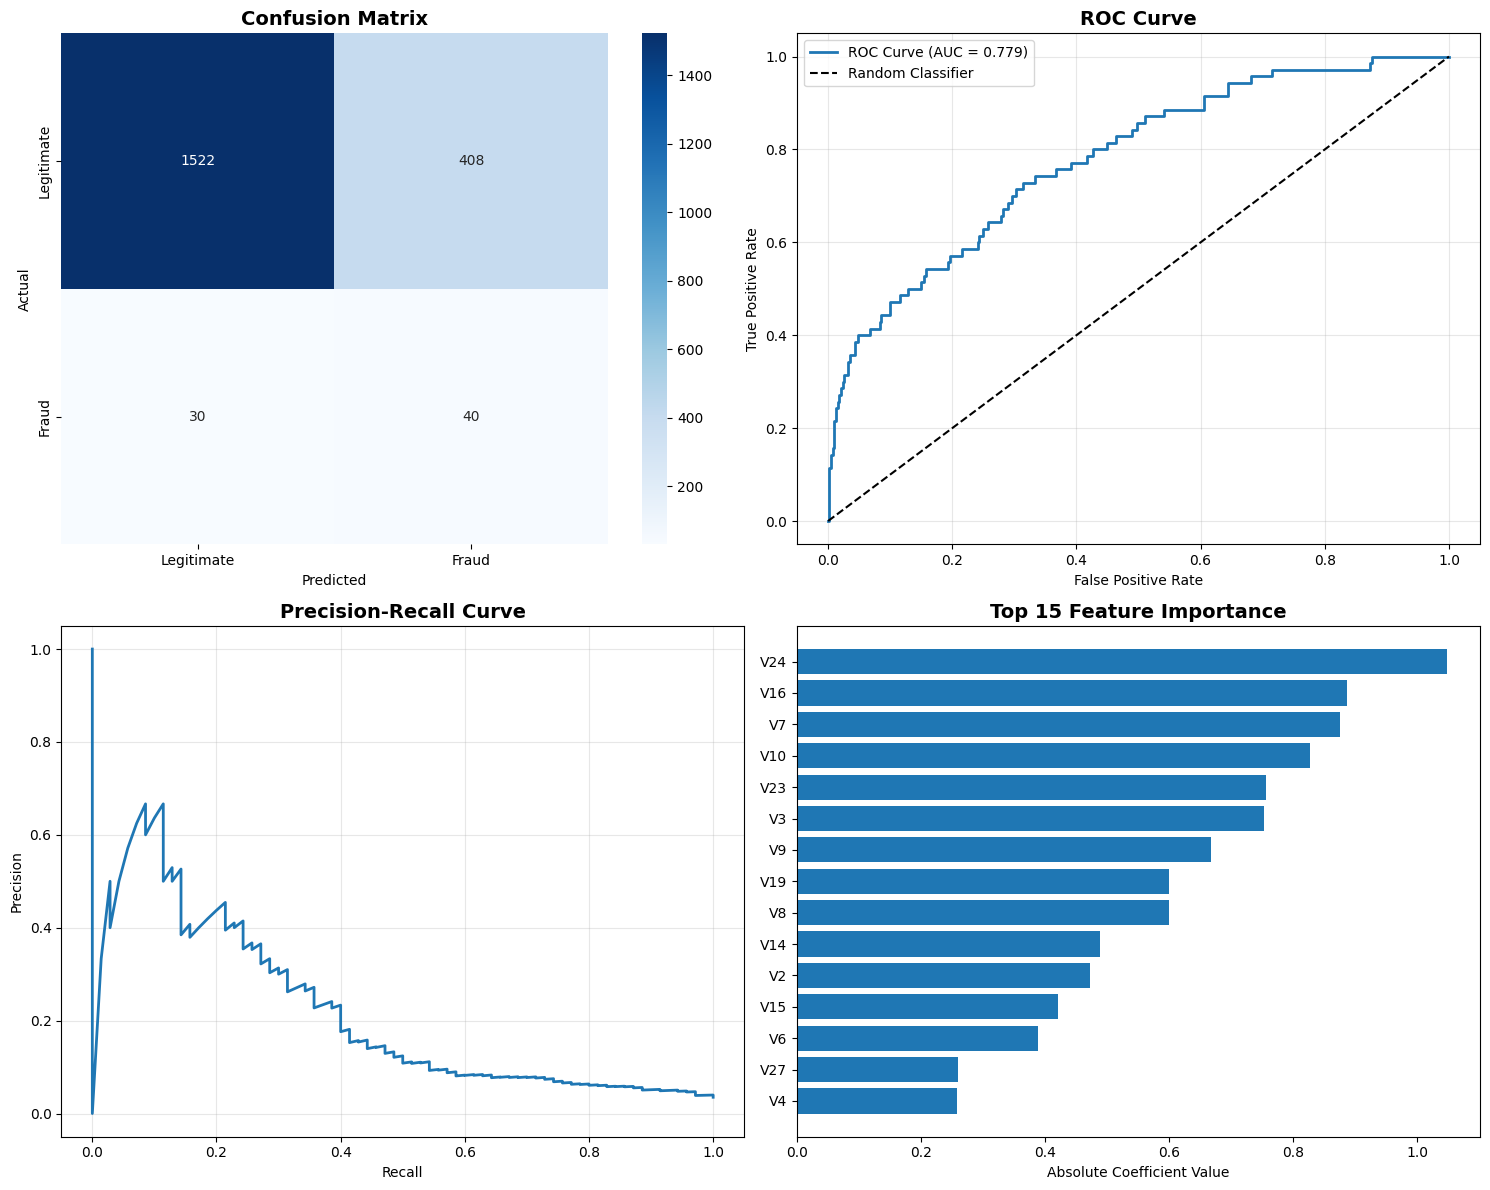


STEP 13: BUSINESS INSIGHTS

Cost Analysis (Example):
False Positives: 408 × $10 = $4080
False Negatives: 30 × $100 = $3000
Total Cost: $7080

Optimal Classification Threshold: 0.3675

Performance with Optimal Threshold:
Precision: 0.0777
Recall: 0.7286
F1-Score: 0.1405

MODEL TRAINING PIPELINE COMPLETED SUCCESSFULLY!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             accuracy_score, precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================================
# 1. GENERATE SYNTHETIC DATASET (Similar to Credit Card Fraud Dataset)
# ============================================================================
print("="*80)
print("STEP 1: GENERATING SYNTHETIC DATASET")
print("="*80)

# For demonstration, we'll create a synthetic dataset
# In real scenario, you would load: df = pd.read_csv('creditcard.csv')
from sklearn.datasets import make_classification

n_samples = 10000
X, y = make_classification(
    n_samples=n_samples,
    n_features=28,
    n_informative=20,
    n_redundant=5,
    n_classes=2,
    weights=[0.97, 0.03],  # Imbalanced: 97% legitimate, 3% fraud
    flip_y=0.01,
    random_state=42
)

# Create a DataFrame
feature_cols = [f'V{i}' for i in range(1, 29)]
df = pd.DataFrame(X, columns=feature_cols)

# Add Time and Amount features (common in credit card datasets)
df['Time'] = np.random.exponential(scale=5000, size=n_samples)
df['Amount'] = np.random.exponential(scale=100, size=n_samples)
df['Class'] = y

print(f"Dataset created with {n_samples} transactions")
print(f"Shape: {df.shape}")
print(f"\nClass distribution:\n{df['Class'].value_counts()}")
print(f"Fraud percentage: {(df['Class'].sum() / len(df)) * 100:.2f}%")

# ============================================================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
print("\n" + "="*80)
print("STEP 2: EXPLORATORY DATA ANALYSIS")
print("="*80)

# Basic statistics
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sum())

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# ============================================================================
# 3. DATA CLEANING
# ============================================================================
print("\n" + "="*80)
print("STEP 3: DATA CLEANING")
print("="*80)

# Remove duplicates if any
df_clean = df.drop_duplicates()
print(f"Rows after removing duplicates: {len(df_clean)}")

# Handle missing values (if any)
if df_clean.isnull().sum().sum() > 0:
    df_clean = df_clean.dropna()
    print(f"Rows after removing missing values: {len(df_clean)}")

# Remove outliers in Amount using IQR method
Q1 = df_clean['Amount'].quantile(0.25)
Q3 = df_clean['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Keep extreme values for fraud detection (outliers might be fraudulent)
# So we'll be lenient with outlier removal
print(f"\nAmount range before outlier treatment: [{df_clean['Amount'].min():.2f}, {df_clean['Amount'].max():.2f}]")

# ============================================================================
# 4. FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("STEP 4: FEATURE ENGINEERING")
print("="*80)

# Create new features
df_clean['Amount_log'] = np.log1p(df_clean['Amount'])  # Log transformation
df_clean['Time_hour'] = (df_clean['Time'] / 3600) % 24  # Convert to hour of day
df_clean['Time_day'] = (df_clean['Time'] / 86400).astype(int)  # Day number

# Create interaction features (example)
df_clean['V1_V2_interaction'] = df_clean['V1'] * df_clean['V2']
df_clean['Amount_Time_ratio'] = df_clean['Amount'] / (df_clean['Time'] + 1)

print("New features created:")
print("- Amount_log: Log-transformed amount")
print("- Time_hour: Hour of the day")
print("- Time_day: Day number")
print("- V1_V2_interaction: Interaction term")
print("- Amount_Time_ratio: Ratio feature")

# ============================================================================
# 5. FEATURE SELECTION AND PREPARATION
# ============================================================================
print("\n" + "="*80)
print("STEP 5: FEATURE SELECTION AND PREPARATION")
print("="*80)

# Select features for modeling
features_to_drop = ['Time', 'Amount', 'Class']  # Drop original Time and Amount
X = df_clean.drop(columns=features_to_drop)
y = df_clean['Class']

print(f"\nFeatures selected: {X.shape[1]}")
print(f"Feature names: {list(X.columns)[:10]}... (showing first 10)")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set fraud rate: {y_train.sum() / len(y_train) * 100:.2f}%")
print(f"Test set fraud rate: {y_test.sum() / len(y_test) * 100:.2f}%")

# ============================================================================
# 6. FEATURE SCALING
# ============================================================================
print("\n" + "="*80)
print("STEP 6: FEATURE SCALING")
print("="*80)

# Use RobustScaler as it's less sensitive to outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using RobustScaler")
print(f"Train set mean: {X_train_scaled.mean():.4f}")
print(f"Train set std: {X_train_scaled.std():.4f}")

# ============================================================================
# 7. HANDLE CLASS IMBALANCE
# ============================================================================
print("\n" + "="*80)
print("STEP 7: HANDLING CLASS IMBALANCE WITH SMOTE")
print("="*80)

# Apply SMOTE to create synthetic samples for minority class
smote = SMOTE(random_state=42, sampling_strategy=0.5)  # 50% ratio after SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set size: {X_train_scaled.shape[0]}")
print(f"Original fraud cases: {y_train.sum()}")
print(f"Resampled training set size: {X_train_resampled.shape[0]}")
print(f"Resampled fraud cases: {y_train_resampled.sum()}")
print(f"New fraud rate: {y_train_resampled.sum() / len(y_train_resampled) * 100:.2f}%")

# ============================================================================
# 8. MODEL TRAINING - BASELINE
# ============================================================================
print("\n" + "="*80)
print("STEP 8: BASELINE LOGISTIC REGRESSION MODEL")
print("="*80)

# Train baseline model
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_baseline = lr_baseline.predict(X_test_scaled)
y_pred_proba_baseline = lr_baseline.predict_proba(X_test_scaled)[:, 1]

print("\nBaseline Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_baseline):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_baseline):.4f}")

# ============================================================================
# 9. HYPERPARAMETER TUNING
# ============================================================================
print("\n" + "="*80)
print("STEP 9: HYPERPARAMETER TUNING WITH GRID SEARCH")
print("="*80)

# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_resampled, y_train_resampled)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")

# ============================================================================
# 10. FINAL MODEL TRAINING
# ============================================================================
print("\n" + "="*80)
print("STEP 10: TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("="*80)

# Train final model with best parameters
lr_final = grid_search.best_estimator_

# Predictions
y_pred_final = lr_final.predict(X_test_scaled)
y_pred_proba_final = lr_final.predict_proba(X_test_scaled)[:, 1]

print("\nFinal Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_final):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_final):.4f}")

# ============================================================================
# 11. DETAILED METRICS AND EVALUATION
# ============================================================================
print("\n" + "="*80)
print("STEP 11: DETAILED EVALUATION METRICS")
print("="*80)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=['Legitimate', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives: {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives: {cm[1, 1]}")

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print(f"\nSpecificity (True Negative Rate): {specificity:.4f}")
print(f"False Positive Rate: {fp / (fp + tn):.4f}")
print(f"False Negative Rate: {fn / (fn + tp):.4f}")

# ============================================================================
# 12. VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("STEP 12: CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_xticklabels(['Legitimate', 'Fraud'])
axes[0, 0].set_yticklabels(['Legitimate', 'Fraud'])

# 2. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_final)
axes[0, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba_final):.3f})', linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_final)
axes[1, 0].plot(recall, precision, linewidth=2)
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature Importance (Top 15)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(lr_final.coef_[0])
}).sort_values('importance', ascending=False).head(15)

axes[1, 1].barh(range(len(feature_importance)), feature_importance['importance'])
axes[1, 1].set_yticks(range(len(feature_importance)))
axes[1, 1].set_yticklabels(feature_importance['feature'])
axes[1, 1].set_xlabel('Absolute Coefficient Value')
axes[1, 1].set_title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('fraud_detection_results.png', dpi=300, bbox_inches='tight')
print("Visualizations saved as 'fraud_detection_results.png'")
plt.show()

# ============================================================================
# 13. BUSINESS INSIGHTS
# ============================================================================
print("\n" + "="*80)
print("STEP 13: BUSINESS INSIGHTS")
print("="*80)

# Calculate cost-benefit analysis (example)
cost_false_positive = 10  # Cost of investigating legitimate transaction
cost_false_negative = 100  # Cost of missing a fraudulent transaction

total_cost = (fp * cost_false_positive) + (fn * cost_false_negative)
print(f"\nCost Analysis (Example):")
print(f"False Positives: {fp} × ${cost_false_positive} = ${fp * cost_false_positive}")
print(f"False Negatives: {fn} × ${cost_false_negative} = ${fn * cost_false_negative}")
print(f"Total Cost: ${total_cost}")

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]
print(f"\nOptimal Classification Threshold: {optimal_threshold:.4f}")

# Predictions with optimal threshold
y_pred_optimal = (y_pred_proba_final >= optimal_threshold).astype(int)
print(f"\nPerformance with Optimal Threshold:")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_optimal):.4f}")

print("\n" + "="*80)
print("MODEL TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)